# BICIMAD SPARK
Sara Antón Fernández \
Chenjie Huang \
Alejandro Leal Castaño

## Motivación
A partir de los datos de BICIMAD del mes de julio de 2017 y utilizando spark vamos a analizar:
- La lista de viajes en los que se sale y llega al mismo sitio (misma estación de salida y llegada).
- Duración media de viaje y uso medio por usuario al dia.
- Cuales son los viajes más largos y más cortos.
- Las estaciones más concurridas (salida y llegada).
- Estudio de los usos por cada día por medio de una gráfica.
- Estudio de los usos según la edad por medio de una gráfica.

In [2]:
from pyspark import SparkContext
import json

sc = SparkContext()

22/05/21 11:19:46 WARN Utils: Your hostname, alejandro-hpelitebook840g2 resolves to a loopback address: 127.0.1.1; using 10.8.22.181 instead (on interface wlo1)
22/05/21 11:19:46 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/21 11:19:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# RDD base y extraccion de datos

text_sample = '201707_movements.json'

rdd_base = sc.textFile(text_sample)

def mapper(line):
    data = json.loads(line)
    # u_t = data['user_type']
    u_c = data['user_day_code']
    start = data['idunplug_station']
    end = data['idplug_station']
    time = data['travel_time']
    date = data['unplug_hourTime']
    u_a = data['ageRange']
    return u_c, start, end, time, date, u_a

rdd = rdd_base.map(mapper)
rdd.count()

351289

## Análisis 1

Lista de viajes en la que se sale y llega al mismo sitio.
Salen y vuelven a la misma estación.

Una de las posibles interpretaciones de este resultado es comprobar la cantidad de personas usan este servicio con el propósito de dar un paseo o entrenar.

**Datos necesarios**:
- 'idplug_station'
- 'idunplug_station'


In [16]:
# Filtrar cogiendo solo los que cumplan que "start = end"
rdd_ciclos = rdd.filter(lambda x: x[1] == x[2])
rdd_ciclos.count()

22085

## Análisis 2

En este segundo análisis se obtendrán las medias de duración por viaje (sin tener en cuenta si una persona realiza más de un viaje) y de uso por persona en el día.

**Datos necesarios**:
- 'user_day_code'
- 'travel_time'

### Tiempo medio por viaje

En este caso, basta simplemente con tomar el tiempo de viaje y calcular los totales para la media.

In [21]:
rdd_travelTime = rdd.map(lambda x: x[3])

total_travels = rdd_travelTime.count()
total_travelTime = rdd_travelTime.sum()
average_travelTime = total_travelTime/total_travels

print(f'Viajes: {total_travels}')
print('Duración total: ' + format(total_travelTime/3600, ".2f") + ' horas')
print('Media por viaje: ' + format(average_travelTime/60, ".2f") + ' minutos')

Viajes: 351289
Duración total: 121464.96 horas
Media por viaje: 20.75 minutos


### Tiempo medio por identificador diario (persona)

En ese caso se toma como clave el identificador y como valor la duración del viaje. Después se agrupa por clave y se suman todas las duraciones de los viajes con mapValues. Por último, se toman únicamente los valores para calcular la media por persona en el día.

In [19]:
rdd_travelTime_id = rdd.map(lambda x: (x[0], x[3]))\
                        .groupByKey()\
                        .mapValues(sum)\
                        .values()

total_travels_id = rdd_travelTime_id.count()
total_travelTime_id = rdd_travelTime_id.sum()
average_travelTime_id = total_travelTime_id/total_travels_id

print(f'Personas (id): {total_travels_id}')
print('Duración total: ' + format(total_travelTime_id/3600, ".2f") + ' horas')
print('Media por persona: ' + format(average_travelTime_id/60, ".2f") + ' minutos')

Personas (id): 184696
Duración total: 121464.95555555556 horas
Media por persona: 39.46 minutos


## Análisis 3

Ahora se pretende visualizar los viajes más largos y más cortos que se han realizado, filtrando aquellos que no sean correctos o no sean representativos con lo que se desea obtener.

\
**Datos necesarios**:
- 'travel_time'

\
Procedimiento:
- Filtramos para eliminar los viajes que duren más de 24 horas y los viajes que duren menos de 15 segundos y además las estaciones de salida y llegada no coincidan. Esto permite eliminar viajes en los que no se haya devuelto la bicicleta después de usarla y datos que no son correctos (ya que no es verosímil que un viaje entre 2 estaciones distintas dure tan poco).
- Tomamos los 10 viajes más largos y más cortos en cada caso.

In [24]:
rdd_filter_dur = rdd.filter(lambda x: x[3] <= 86400 and not (x[1] != x[2] and x[3] <= 15))
                
rdd_llt = rdd_filter_dur.sortBy(lambda x: -x[3]).take(10)
rdd_lst = rdd_filter_dur.sortBy(lambda x: x[3]).take(10)

In [26]:
print(rdd_llt, '\n')
print(rdd_lst)

[('281b6faae5256582c9504bd2569ddb85c0aa2e3ef65025c1e28cb4e4ac61b947', 169, 128, 86313, {'$date': '2017-07-16T08:00:00.000+0200'}, 1), ('1e4ed5e958a1cc8f850de6c6a5c532ee1440b94580bf99edf614d1e242db62a2', 133, 163, 85851, {'$date': '2017-07-17T08:00:00.000+0200'}, 1), ('d8fe1e5bda6dcd4d03053cc75e926502b1c66a63edcd2b42eda0127eca8806bd', 44, 86, 85324, {'$date': '2017-07-29T16:00:00.000+0200'}, 5), ('206caa6bb26bca817c233b71cc10ad4b647feb597714ace7abb649c49e52ee12', 13, 58, 84006, {'$date': '2017-07-15T08:00:00.000+0200'}, 4), ('9375169669c50d81051f74396bdcf15f29c90b97d3530659f9961c74c5230d0b', 79, 108, 82562, {'$date': '2017-07-12T17:00:00.000+0200'}, 3), ('9375169669c50d81051f74396bdcf15f29c90b97d3530659f9961c74c5230d0b', 79, 108, 82053, {'$date': '2017-07-12T17:00:00.000+0200'}, 3), ('ad582db59bf542a347cf1281b2a696a932bc81b3f1b38bf44be2fdf399dc8a00', 89, 41, 79971, {'$date': '2017-07-24T09:00:00.000+0200'}, 4), ('d4666c4ad07c5fdcf96ce90e033680b37c2b845b269dc50ac5063ecbee70795e', 21, 95,

## Análisis 4

Este análisis tiene como objetivo estudiar cuáles son las estaciones mas concurridas. Esto permite ver qué estaciones son más propensas a necesitar bicicletas o sea necesario redistribuirlas en otras estaciones por la afluencia de viajes de llegada a dichas estaciones.

\
**Datos necesarios**:
- 'idplug_station'
- 'idunplug_station'

\
Procedimiento:
- Hacemos un map para tomar las estaciones de salida y entrada.
- Con mapValues(sum) calculamos la cantidad de bicicletas que han salido / entrado en dichas estaciones.
- Ordenamos por valor y obtenemos una lista de tuplas donde el primer elemento es la estación y el segundo el número de viajes que empiezan o salen de dicha estación. 

In [10]:

rdd_stations_out = rdd.map(lambda x: (x[1], 1))\
                        .groupByKey()\
                        .mapValues(sum)\
                        .sortBy(lambda x: x[1], ascending=False)

rdd_stations_in = rdd.map(lambda x: (x[2], 1))\
                        .groupByKey()\
                        .mapValues(sum)\
                        .sortBy(lambda x: x[1], ascending=False)

print(rdd_stations_out.take(10))
print(rdd_stations_in.take(10))

[(43, 5491), (163, 5070), (57, 4853), (135, 4474), (129, 4331), (90, 3847), (168, 3776), (132, 3754), (149, 3740), (45, 3621)]


[(43, 5521), (163, 5099), (57, 4826), (135, 4739), (129, 4440), (168, 3939), (132, 3808), (90, 3808), (149, 3772), (45, 3685)]


## Análisis 5

Se pretende ahora hacer una gráfica con los usos o viajes que se han producido a lo largo de un mes con el objetivo de observar tendencias dependiendo del día de la semana.

Estos datos se pueden usar para mejorar la coordinación entre los trabajadores de la empresa.

\
**Datos necesarios**:
- 'unplug_hourTime'

\
Procedimiento:
- Hacer un map con un lambda para crear una tupla con los días como clave.
- Hacer un countByKey para tener como valor la cantidad de viajes que se hacen por día. Así tenemos un diccionario donde las claves son los días y los valores son la cantidad de viajes realizados en ese día.

In [11]:
dict_day = rdd.map(lambda x: (x[4]['$date'][8:10], _))\
                .countByKey()

print(dict_day)

defaultdict(<class 'int'>, {'01': 8856, '02': 8420, '03': 12873, '04': 14057, '05': 14347, '06': 6925, '07': 8548, '08': 8695, '09': 9058, '10': 13155, '11': 13739, '12': 14113, '13': 13396, '14': 12415, '15': 8520, '16': 8264, '17': 12507, '18': 13183, '19': 13469, '20': 13688, '21': 12876, '22': 8856, '23': 7899, '24': 12380, '25': 13173, '26': 13395, '27': 13991, '28': 12581, '29': 8543, '30': 7788, '31': 11579})


Importamos la librería matplotlib.pyplot. Ponemos los días en el eje x y la cantidad de viajes en el eje y.

In [12]:
import matplotlib.pyplot as plt

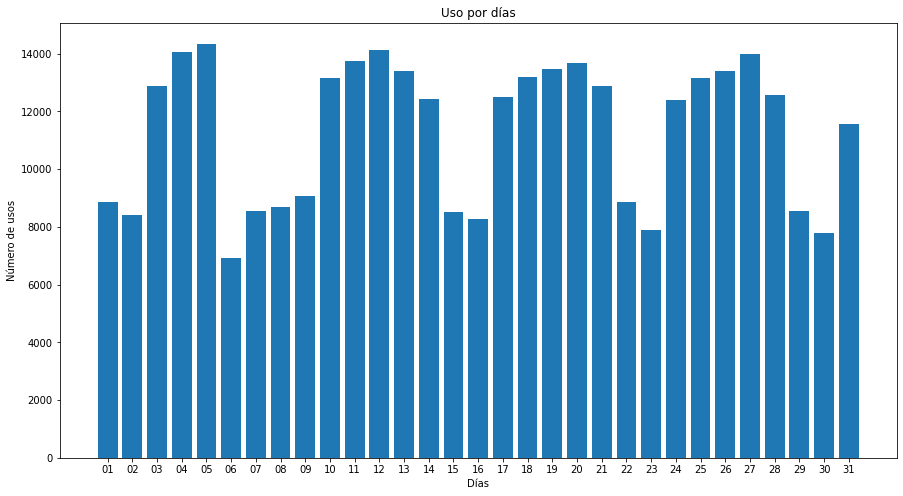

In [13]:
days = dict_day.keys()
num_usage = dict_day.values()

plt.figure(figsize=(15,8))
plt.bar(days, num_usage)
plt.ylabel('Número de usos')
plt.xlabel('Días')
plt.title('Uso por días')

plt.show()

Como se puede observar, la tendencia de uso se ve incrementado en tramos de 5 días que se corresponden con días laborales/hábiles mientras que se reduce el uso de biciMAD en días como el sábado o domingo. 

## Análisis 6

El objetivo de este estudio consiste en encontrar en qué rango de edades es más popular el uso de este servicio. Esto permite un mejor entendimiendo de la población y posibilita que la publicidad esté dirigida a ciertos grupos de edad (como por ejemplo, promover este servicio entre los jóvenes).

\
**Datos necesarios**:
- 'ageRange'

\
Procedimiento:
- Hacer un map con un lambda para crear una tupla con los días como primer argumento
- Hacer un groupByKey para agrupar los viajes por las edades de los usuarios y hacemos un mapValues(sum) para sumar los viajes
- Por último, nos quedamos con los valores, que son los viajes por los rangos de edad ordenados de los usuarios más jóvenes a los más mayores, estando primero el tramo de edades desconocidas.

In [20]:
rdd_age = rdd.map(lambda x: (x[5], 1))\
                .groupByKey()\
                .sortByKey()\
                .mapValues(sum)\
                .values()

age_num_usage = rdd_age.collect()

age_ranges = ['desconocido', '0-16', '17-18', '19-26', '27-40', '41-65', '+66']

for e in zip(age_ranges, age_num_usage):
    print(f'{e[0]}: {e[1]}')

desconocido: 69120
0-16: 8434
17-18: 5205
19-26: 37014
27-40: 158278
41-65: 71593
+66: 1645


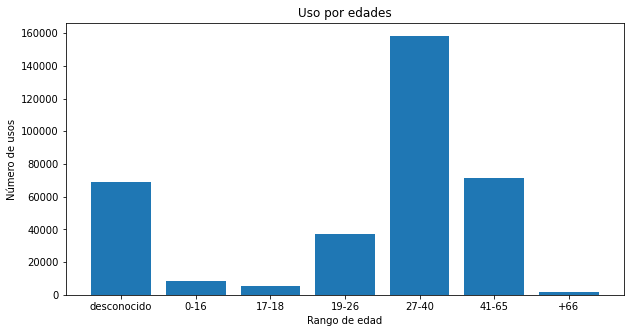

In [15]:
plt.figure(figsize=(10,5))
plt.bar(age_ranges, age_num_usage)
plt.ylabel('Número de usos')
plt.xlabel('Rango de edad')
plt.title('Uso por edades')

plt.show()

Al interpretar esta gráfica se puede ver que el rango de edades que hace un mayor uso de biciMAD con una diferencia considerable es de 27 a 40 años, duplicando los viajes del siguiente grupo.

De los usos de los que no se puede determinar el rango de edad pueden pertenecer a movimientos que correspondan a operarios de la empresa (para realizar reparaciones por ejemplo) o de usuarios de los que no se disponga este tipo de información.